## Objetivo

El objetivo de este trabajo es entrenar un modelo de Machine Learning que permita predecir fallos en maquinas industriales a partir de datos de sensores y condiciones de operacion. Se trabajara el problema como un problema de clasificacion binaria, donde se buscara predecir si una maquina fallara o no en un futuro cercano. Se considera como resultado satisfactorio que el modelo final logre una precision del 90% o superior en la prediccion de fallos en el conjunto de test.

## Analisis exploratorio de datos (EDA)

El dataset a utilizar esta formado por infromacion provenientes de sensores y otras variables que describen las condiciones de operacion de diferentes maquinas y columnas que indican el fallo de ciertos componentes de las mismas como tambien fallos generales. 

Dado a que los datos de mantenimiento predictivo suelen ser dificiles de obtener ya que las empresas no suelen compartirlos, se utilizara un dataset sintetico explicado en [Explainable Artificial Intelligence for Predictive Maintenance Applications](https://www.semanticscholar.org/paper/Explainable-Artificial-Intelligence-for-Predictive-Matzka/b609c8e9ec6a2b8c642810953ef6dffe5766f7c1) que se puede descargar de forma gratuita del siguiente [enlace](https://archive.ics.uci.edu/dataset/601/ai4i+2020+predictive+maintenance+dataset).

### Columnas del dataset

El conjunto de datos consta de 10,000 puntos de datos almacenados como filas con 14 características en columnas: 
- **UID**: identificador único que varía de 1 a 10,000 
- **product ID**: compuesto por una letra L, M o H para variantes de calidad de producto baja (60% de todos los productos), media (30%) y alta (10%), y un número de serie específico de la variante 
- **Type**: tipo de máquina, con 3 tipos diferentes L, M y H
- **air temperature [K]**: generada utilizando un proceso de caminata aleatoria, normalizada posteriormente a una desviación estándar de 2 K alrededor de 300 K  
- **process temperature [K]**: generada utilizando un proceso de caminata aleatoria normalizada a una desviación estándar de 1 K, añadida a la temperatura del aire más 10 K  
- **rotational speed [rpm]**: calculada a partir de una potencia de 2860 W, superpuesta con un ruido distribuido normalmente  
- **torque [Nm]**: valores de torque distribuidos normalmente alrededor de 40 Nm con una σ = 10 Nm y sin valores negativos  
- **tool wear [min]**: las variantes de calidad H/M/L añaden 5/3/2 minutos de desgaste a la herramienta utilizada en el proceso  
- **machine failure**: indica si la máquina ha fallado bajo las condiciones indicadas por los campos anteriores, si alguno de los modos de fallo es verdadero.  

Modos de fallo:
- **TWF**: fallo de desgaste de la herramienta, si el desgaste de la herramienta supera un umbral de 50 minutos  
- **HDF**: fallo de desgaste de la herramienta, si el desgaste de la herramienta supera un umbral de 100 minutos  
- **PWF**: fallo de la herramienta de proceso, si la temperatura del proceso supera un umbral de 350 K  
- **OSF**: fallo de sobrecalentamiento, si la temperatura del aire supera un umbral de 350 K  
- **RNF**: fallo de velocidad de rotación, si la velocidad de rotación supera un umbral de 3000 rpm


In [303]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import (
    KFold, 
    train_test_split,
    cross_val_score,
    GridSearchCV
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    roc_curve, auc, 
    ConfusionMatrixDisplay, 
    classification_report
)

from imblearn.over_sampling import SMOTE, SMOTENC

In [304]:
dataset = pd.read_csv('ai4i+2020+predictive+maintenance+dataset/ai4i2020.csv')
dataset.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


A priori vamos a descartar la columna **UDI** ya que, al ser un identificador único por fila, no aporta información relevante para el modelo. A modo de target, utilizaremos la columna **machine failure** que indica el fallo de la maquina y descartamos las columnas de los modos de fallo para trabajar el problema como una clasificación binaria.

In [305]:
to_drop = ['UDI', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']

dataset = dataset.drop(columns=to_drop)
dataset.head()

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
0,M14860,M,298.1,308.6,1551,42.8,0,0
1,L47181,L,298.2,308.7,1408,46.3,3,0
2,L47182,L,298.1,308.5,1498,49.4,5,0
3,L47183,L,298.2,308.6,1433,39.5,7,0
4,L47184,L,298.2,308.7,1408,40.0,9,0


In [306]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Product ID               10000 non-null  object 
 1   Type                     10000 non-null  object 
 2   Air temperature [K]      10000 non-null  float64
 3   Process temperature [K]  10000 non-null  float64
 4   Rotational speed [rpm]   10000 non-null  int64  
 5   Torque [Nm]              10000 non-null  float64
 6   Tool wear [min]          10000 non-null  int64  
 7   Machine failure          10000 non-null  int64  
dtypes: float64(3), int64(3), object(2)
memory usage: 625.1+ KB


In [307]:
dataset['Type'] = dataset['Type'].astype('category')
dataset['Machine failure'] = dataset['Machine failure'].astype('category')

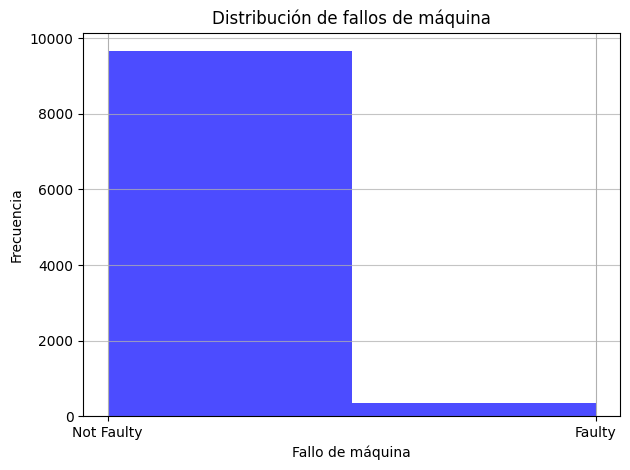

In [308]:
dataset['Machine failure'].hist(bins=2, color='blue', alpha=0.7)
plt.title('Distribución de fallos de máquina')
plt.xlabel('Fallo de máquina')
plt.ylabel('Frecuencia')
plt.xticks([0, 1], ['Not Faulty', 'Faulty'])
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

Vemos que se presenta un desbalance muy fuerte en el target, lo cual es de esperar en un problema de mantenimiento predictivo, ya que las fallas son eventos poco frecuentes. Esto puede afectar el rendimiento del modelo, por lo que se deben considerar técnicas para manejar el desbalance, como el sobremuestreo de la clase minoritaria o el submuestreo de la clase mayoritaria.


### Analisis de variables categoricas

In [309]:
unique = dataset['Product ID'].nunique()
print(f'Proporcion de Product Ids unicos: {unique / len(dataset)}')

Proporcion de Product Ids unicos: 1.0


Tipos de máquina:
Type
L    0.6000
M    0.2997
H    0.1003
Name: count, dtype: float64


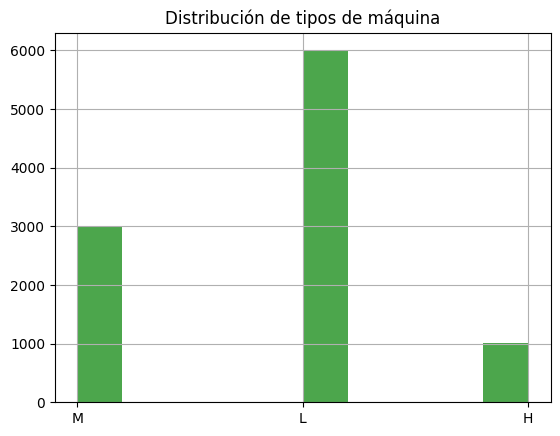

In [310]:
n_counts = dataset['Type'].value_counts()
print('Tipos de máquina:')
print(f'{n_counts / len(dataset)}')

dataset['Type'].hist(color='green', alpha=0.7)
plt.title('Distribución de tipos de máquina')
plt.show()

Vemos que el **Product ID** es unico para cada fila, por lo que no aporta información relevante para el modelo. Por otro lado, la columna **Type** tiene 3 tipos diferentes de maquinas (L, M y H) con una distribución de 60%, 30% y 10% respectivamente. Esto puede ser relevante para el modelo ya que las diferentes maquinas pueden tener diferentes comportamientos y fallos. Descartamos la columna **Product ID**.

In [311]:
dataset.drop(columns=['Product ID'], inplace=True)

### Analisis de variables numericas

Graficamos las variables numericas para ver su distribucion y hacemos un analisis de correlacion entre ellas. 

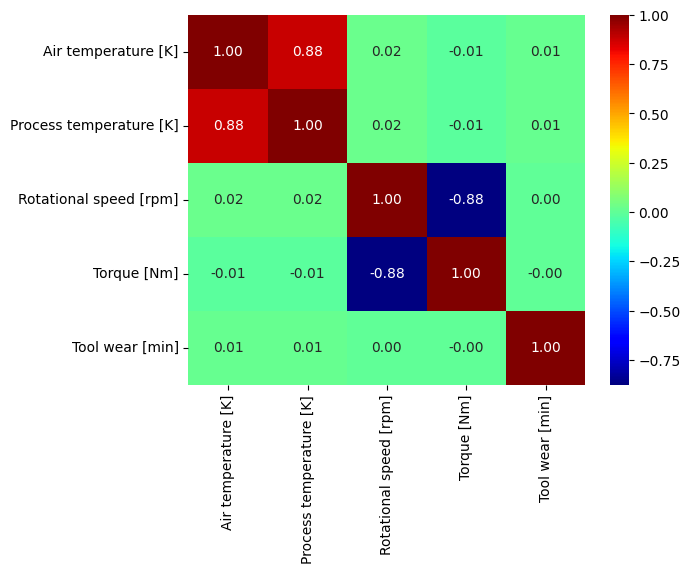

In [312]:
correlation = dataset.corr(numeric_only=True)
plt.figure()
sns.heatmap(
    correlation, 
    annot=True, 
    fmt=".2f",
    cmap='jet',
    annot_kws={"size": 10},  # Increased font size for annotations
    cbar=True)
plt.show()

Tenemos dos pares de variables que presentan una correlacion alta, **air temperature** y **process temperature** , que presentan una correlacion directa y **rotational speed** y **torque** con una correlacion inversa. 

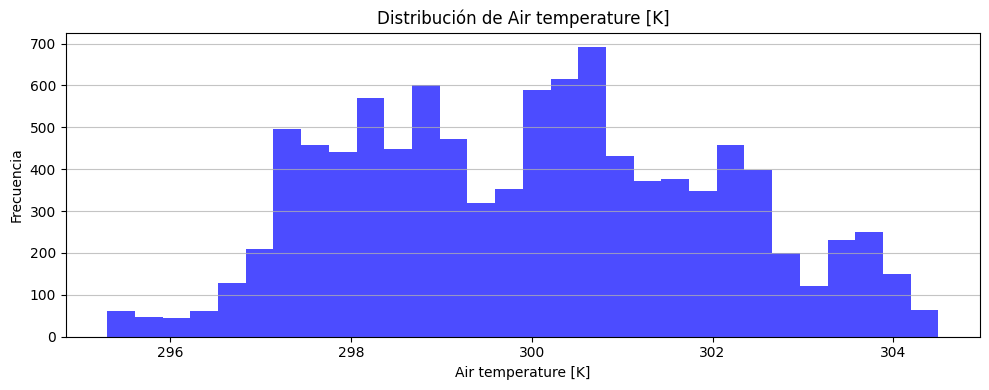

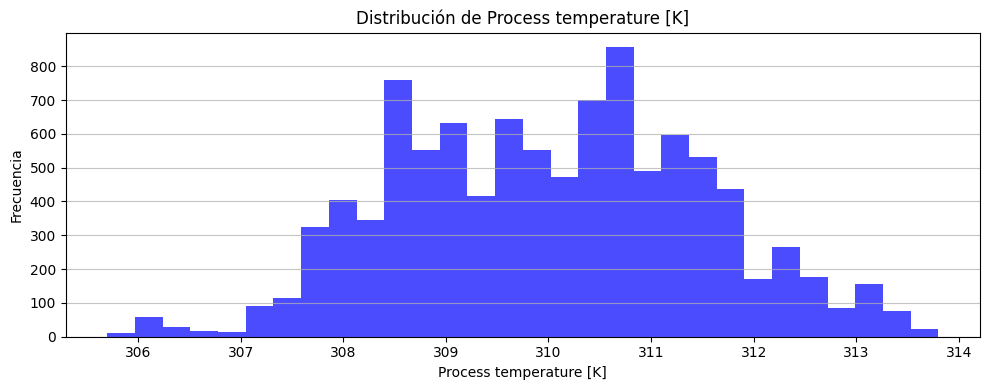

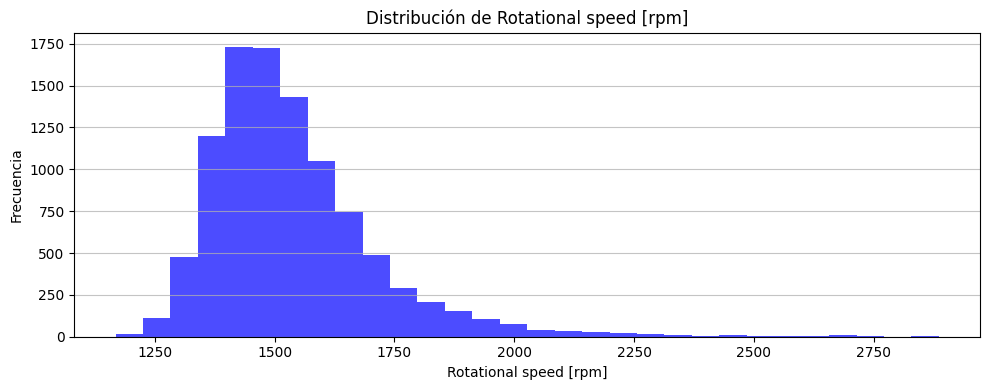

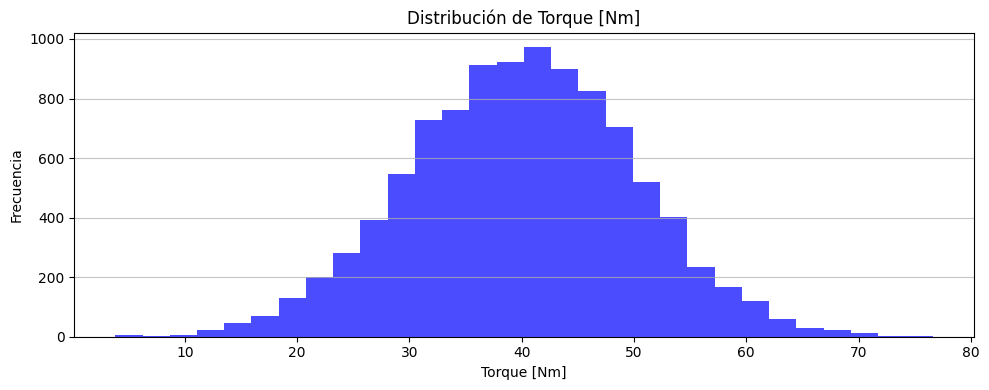

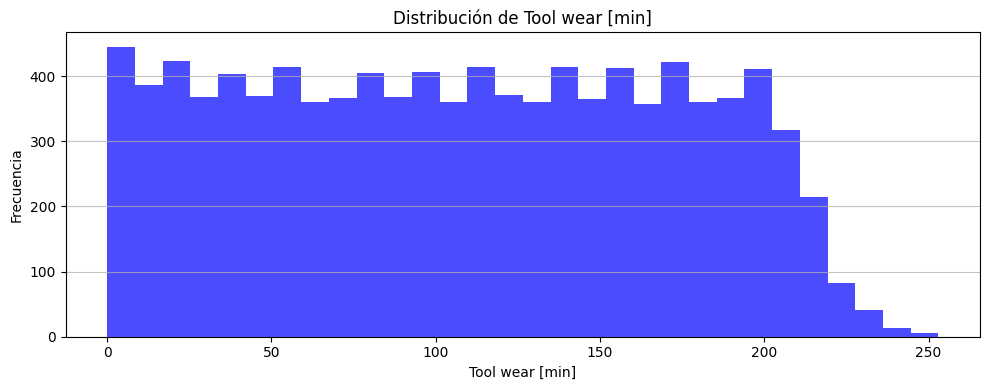

In [313]:
# graficar distribucion de las variables numericas
numeric_cols = dataset.select_dtypes(exclude=['category']).columns
for col in numeric_cols:
    plt.figure(figsize=(10, 4))
    plt.hist(dataset[col], bins=30, color='blue', alpha=0.7)
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.grid(axis='y', alpha=0.75)
    plt.tight_layout()
    plt.show()

## Train - test split y K Fold validation.

En este punto, previo a aplicar tranformaciones globales, realizamos la separacion entre train y test. Utilizamos un 80% de los datos para entrenamiento y un 20% para test. Se aplicara una validacion cruzada de 5 folds con datos de entrenamiento.

In [314]:
# Eliminamos la columna Machine failure para el entrenamiento
y = dataset['Machine failure']
X = dataset.drop(columns=['Machine failure'])

In [315]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Balanceamos el dataset
categorical_indices = [X_train.columns.get_loc(col) for col in ['Type']]  # example
smote = SMOTENC(categorical_features=categorical_indices, random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)


/Users/maximdorogov/anaconda3/envs/computer-vision/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/maximdorogov/anaconda3/envs/computer-vision/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


In [316]:
X_train_balanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15458 entries, 0 to 15457
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Type                     15458 non-null  category
 1   Air temperature [K]      15458 non-null  float64 
 2   Process temperature [K]  15458 non-null  float64 
 3   Rotational speed [rpm]   15458 non-null  int64   
 4   Torque [Nm]              15458 non-null  float64 
 5   Tool wear [min]          15458 non-null  int64   
dtypes: category(1), float64(3), int64(2)
memory usage: 619.2 KB


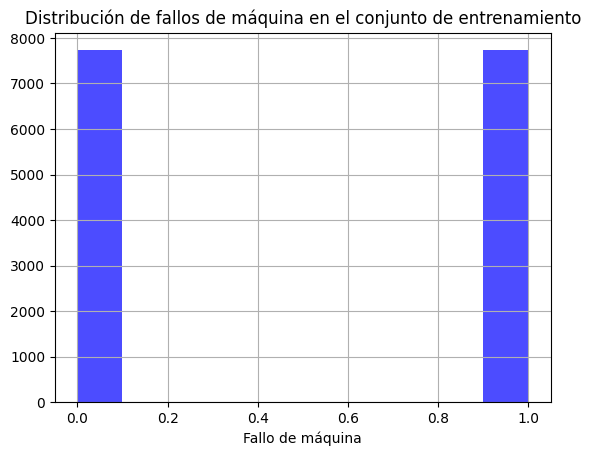

In [317]:
y_train_balanced.hist(color='blue', alpha=0.7)
plt.title('Distribución de fallos de máquina en el conjunto de entrenamiento')
plt.xlabel('Fallo de máquina')
plt.show()

### Codificamos las variables categoricas

Como la variable **Type** presenta una cardinalidad baja vamos a aplicar One Hot Encoding

In [318]:
X_train_balanced = pd.get_dummies(X_train_balanced, columns=['Type'], drop_first=True)
X_train_balanced['Type_L'] = X_train_balanced['Type_L'].astype('category')
X_train_balanced['Type_M'] = X_train_balanced['Type_M'].astype('category')
X_train_balanced.head()

# Repetimos para el conjunto de test
X_test = pd.get_dummies(X_test, columns=['Type'], drop_first=True)
X_test['Type_L'] = X_test['Type_L'].astype('category')
X_test['Type_M'] = X_test['Type_M'].astype('category')  


## Entrenamiento de modelos

Se van a entrenar dos modelos, un clasificador naive bayes para ser usado a modo de baseline y un clasificador SVM.

Para el clasificador Naive Bayes se utilizara el classificador `GaussianNB`. Cuatro de las cinco columnas del dataset presentan distribuciones que podrian aproximarse a gaussianas, y con una correlacion baja entre si pudiendo asumir independencia. Por lo que este clasificador es adecuado para este caso.


In [319]:
numeric_features = X_train_balanced.select_dtypes(exclude=['category']).columns
categorical_features = X_train_balanced.select_dtypes(include=['category']).columns

# Necesitamos que las features sean positivas para bayes, usamos MinMaxScaler 
# para el preprocesamiento.
preprocessor_nb = ColumnTransformer(
    transformers=[("num", MinMaxScaler(), numeric_features),
                  ("cat", "passthrough", categorical_features)]
)
model_nb = Pipeline(steps=[
    ("preprocessor", preprocessor_nb),
    ("classifier", GaussianNB())
])
# Hacemos validacion cruzada para el modelo Naive Bayes
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [320]:
train_scores = cross_val_score(
    model_nb, X_train_balanced, y_train_balanced, cv=kf)
test_score = model_nb.fit(
    X_train_balanced, y_train_balanced).score(X_test, y_test)
print("Cross Validation scores:", train_scores)
print("Cross Validation scores:", train_scores.mean())
print("Test score:", test_score)

Cross Validation scores: [0.80756792 0.80109961 0.81112549 0.79812358 0.81656422]
Cross Validation scores: 0.8068961635060349
Test score: 0.7625


Para el clasificador SVM, como punto de partida se utilizara un kernel radial, `RBF`, con sus hiperparametros de regularizacion y gamma por defecto. Este kernel es optimo para datos que no son linealmente separables. En caso de que los resultados no sean satisfactorios se hara una busqueda de hiperparametros para encontrar un kernel adecuado al problema.

In [321]:
# Preprocessor: scale numerical features
preprocessor_svm = ColumnTransformer(
    transformers=[("num", StandardScaler(), numeric_features),
                  ("cat", "passthrough", categorical_features)]
)

# Build pipeline: preprocessing + classifier
model_svm = Pipeline(steps=[
    ("preprocessor", preprocessor_svm),
    ("classifier", SVC())
])

In [322]:
train_scores = cross_val_score(model_svm, X_train_balanced, y_train_balanced, cv=kf)
test_score = model_svm.fit(X_train_balanced, y_train_balanced).score(X_test, y_test)
print("Cross Validation scores:", train_scores)
print("Avg Validation score:", train_scores.mean())
print("Test score:", test_score)

Cross Validation scores: [0.94307891 0.93402329 0.94857697 0.93885474 0.93561954]
Avg Validation score: 0.9400306904450304
Test score: 0.918


Como se esperaba en esta prueba inicial el modelo SVM performa mejor, en terminos de accuracy, que el modelo Naive Bayes. Esto es debido a que el modelo SVM es capaz de capturar relaciones no lineales entre las variables, mientras que el modelo Naive Bayes asume independencia entre las variables y no es capaz de capturar relaciones complejas. 

Si bien los resultados iniciales fueron mejores de lo esperado para ambos modelos, el siguiente analisis se va a enfocar en el modelo SVM y realizara una busqueda de hiperparametros mediante Grid Search para ver cuanto se puede mejorar. Los hiperparametros a optimizar seran la constante de regularizacion `C` y el tipo de `kernel`.


In [323]:
# incluimos la C default que es 1, como parte de la grilla de parametros.
param_grid = {
    'classifier__C': [0.01, 0.11, 1, 10],
    'classifier__kernel': ['rbf', 'linear']
}
grid_search = GridSearchCV(model_svm, param_grid, cv=kf, scoring='accuracy')

In [324]:
grid_search.fit(X_train_balanced, y_train_balanced)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]'],
      dtype='object')),
                                                                        ('cat',
                                                                         'passthrough',
                                                                         Index(['Type_L', 'Type_M'], dtype='object'))])),
                                       ('classifier', SVC())]),
             param_grid={'classifier__C': [0.01, 0.11, 1, 10],
                         'classifier__kernel': ['rbf', 'linear']},
             scoring='accuracy')

In [325]:
print("Best score:", grid_search.best_score_)
print("Best params:", grid_search.best_params_)

Best score: 0.9502519730319172
Best params: {'classifier__C': 10, 'classifier__kernel': 'rbf'}


In [326]:
model_svm = Pipeline(steps=[
    ("preprocessor", preprocessor_svm),
    ("classifier", SVC(C=grid_search.best_params_['classifier__C'],
                        kernel=grid_search.best_params_['classifier__kernel']))
])

# Hacemos fit con los mejores parametros sobre el dataset completo

test_scores = model_svm.fit(X_train_balanced, y_train_balanced).score(X_test, y_test)
print("Test accuracy with best params:", test_scores)

Test accuracy with best params: 0.9305


## Evaluacion

Nos vamos a enfocamos la evaluacion del modelo SVM ya que el modelo que propusimos como baseline no cumple la condicion (autoimpuesta) de superar el 90% de accuracy. Esta condicion si se cumple para el clasificador SVM, por lo que a continuacion se muestran las metricas de evaluacion para los hiperparametros optimos obtenidos mediante Grid Search.

              precision    recall  f1-score   support

  Not Faulty       0.99      0.93      0.96      1932
      Faulty       0.31      0.82      0.45        68

    accuracy                           0.93      2000
   macro avg       0.65      0.88      0.70      2000
weighted avg       0.97      0.93      0.95      2000



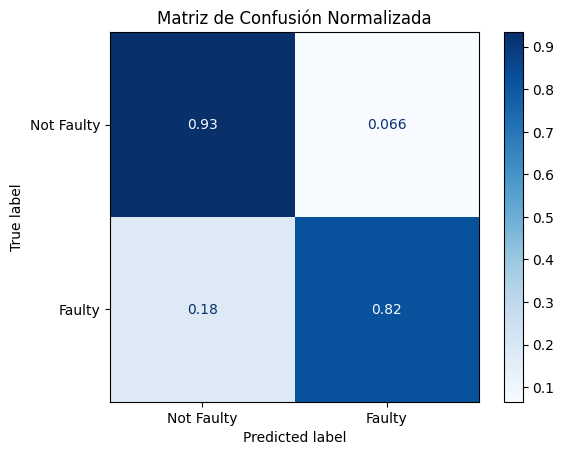

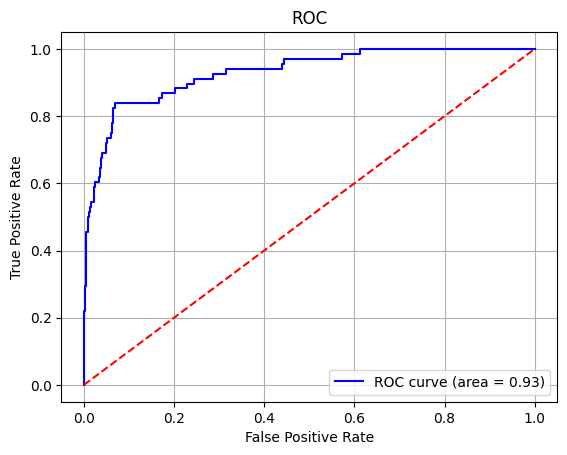

In [327]:
# classification report sobre datos de test
y_pred = model_svm.predict(X_test)
print(classification_report(
    y_test, y_pred, target_names=['Not Faulty', 'Faulty']))

# matrix de confusion
ConfusionMatrixDisplay.from_estimator(
    model_svm, X_test, y_test,
    display_labels=['Not Faulty', 'Faulty'],
    cmap=plt.cm.Blues,
    normalize='true'
)
plt.title('Matriz de Confusión Normalizada')
plt.show()

# Roc curve
y_score = model_svm.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test.cat.codes, y_score)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc='lower right')
plt.grid()
plt.show()

Se observa que el modelo es muy bueno para predecir la clase mayoritaria (no fallo) pero tiene un rendimiento menor para la clase minoritaria (fallo). Esto es de esperar dado el desbalance en el dataset y el soporte de los datos en el conjunto de test. 

## Conclusiones

Se logro entrenar un modelo SVM que supera el 90% de accuracy en la prediccion de fallos en maquinas industriales. La performance del modelo fue consistente en todos los folds de la validacion cruzada y en el conjunto de test. Esto es un indicador de que el preprocesamiento de datos y la seleccion de caracteristicas fueron adecuados para el problema. 

El uso de Grid Search para la optimizacion de hiperparametros fue clave para mejorar la performance del modelo. Se logro aumentar el accuracy de 0.91 a 0.93
para el conjunto de test.

El modelo de baseline, el clasificador Naive Bayes, no logro superar el 90% de accuracy. Esto se debe a que Naive Bayes asume independencia entre las variables y una distribucion normal, si bien algunas variables tenian distribuciones que podian aproximarse a una normal tambien existia cierta correlacion entre las columnas del dataset, lo que afecto su rendimiento.